# FENE beadspring with variable kuhn length experiment data analysis

In [99]:
import os
import typing

import polyflexmd.data_analysis.data.constants as data_constants
import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.pipelines.process as pipeline_process
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.experiment_runner.config as config
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_style("darkgrid")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Read and process data

In [59]:
PATH_EXPERIMENT = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K-vary-d_end/test-5-FENE-beadspring-vary-l_K-vary-d_end/e296c212"
NAME_EC = "test-5-FENE-beadspring-vary-l_K-vary-d_end.toml"
EQUILIBRIUM_ONLY = False
CONTINUE = False
CONTINUE_t_equilibrium = 45000000
N_WORKERS = 16

In [104]:
pandarallel.initialize(
    nb_workers=N_WORKERS,
    progress_bar=False,
    use_memory_fs=None
)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [61]:
CONTINUE = bool(CONTINUE)
CONTINUE_t_equilibrium = int(CONTINUE_t_equilibrium)
EQUILIBRIUM_ONLY = bool(EQUILIBRIUM_ONLY)
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data/initial_system.data"
PATH_EC = PATH_EXPERIMENT / NAME_EC

### Read experiment config

In [62]:
conf = config.read_experiment_config(PATH_EC)
conf

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=4, tasks_per_node=128, ntasks=512, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='', lmod_modules='', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K-vary-d_end.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results'), n_partitions=8, n_tasks_per_partition=64, variables={'kappa_start': 1.0, 'kappa_delta': 5, 'kappa_n_values': 8, 'm_end': 1.5, 'd_end_start': 1.2, 'd_end_delta': 0.2, 'd_end_n_values': 5, 'n_relax_steps': 1000000, 'n_equilibrium_steps': 1000000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntasks=1, cpus_per_task=2, mem_per_cpu=2000), venv_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/polyflexmd/.venv'), system_config=AnchoredFEN

In [63]:
kappas: list[float] = [
    conf.simulation_config.variables["kappa_start"] + conf.simulation_config.variables["kappa_delta"] * i
    for i in range(conf.simulation_config.variables["kappa_n_values"])
]
kappas

[1.0, 6.0, 11.0, 16.0, 21.0, 26.0, 31.0, 36.0]

In [64]:
d_ends: list[float] = [
    conf.simulation_config.variables["d_end_start"] + conf.simulation_config.variables["d_end_delta"] * i
    for i in range(conf.simulation_config.variables["d_end_n_values"])
]
d_ends

[1.2, 1.4, 1.6, 1.8, 2.0]

### Read initial system

In [65]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system.atoms

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,0.000000,0.000000,0.000000,0,0,0
2,1,1,-0.159927,-0.017451,-0.956566,0,0,0
3,1,2,-0.086992,-0.765936,-0.343908,0,0,0
4,1,2,0.059319,0.029401,-0.879569,0,0,0
5,1,2,0.514538,0.823298,-0.558005,0,0,0
...,...,...,...,...,...,...,...,...
508,4,2,11.500683,-0.771811,-0.504867,0,0,0
509,4,2,10.579229,-0.598039,-0.753109,0,0,0
510,4,2,10.236980,-1.059966,0.028165,0,0,0
511,4,2,10.520269,-1.676332,0.721519,0,0,0


In [66]:
system.bonds

,type,atom1,atom2
1,1,1,2
2,1,2,3
3,1,3,4
4,1,4,5
5,1,5,6
...,...,...,...
504,1,507,508
505,1,508,509
506,1,509,510
507,1,510,511


In [67]:
system.angles

,type,atom1,atom2,atom3
1,1,1,2,3
2,1,2,3,4
3,1,3,4,5
4,1,4,5,6
5,1,5,6,7
...,...,...,...,...
500,1,506,507,508
501,1,507,508,509
502,1,508,509,510
503,1,509,510,511


In [68]:
system.box

-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi

### Extract main-axis dataframe

In [69]:
PATH_DATA_PROCESSED = PATH_EXPERIMENT / "data" / "processed"
if CONTINUE:
    PATH_DATA_PROCESSED = PATH_DATA_PROCESSED / "continue"
PATH_DATA_PROCESSED.mkdir(exist_ok=True, parents=True)

In [70]:
PATH_DF_MAIN_AXIS = PATH_DATA_PROCESSED / "main_axis.csv"

In [71]:
if PATH_DF_MAIN_AXIS.exists():
    df_main_axis = pd.read_csv(PATH_DF_MAIN_AXIS)
else:
    df_main_axis = transform.unfold_coordinates_df(system.atoms, system).groupby("molecule-ID").head(n=2)
    df_main_axis.to_csv(PATH_DF_MAIN_AXIS, index=False)
df_main_axis

,molecule-ID,type,x,y,z,ix,iy,iz
0,1,1,0.000000,0.000000,0.000000,0,0,0
1,1,1,-0.159927,-0.017451,-0.956566,0,0,0
2,2,1,0.000000,0.000000,0.000000,0,0,0
3,2,1,-0.682228,-0.434785,-0.535188,0,0,0
4,3,1,0.000000,0.000000,0.000000,0,0,0
5,3,1,-0.121778,-0.306041,-0.912364,0,0,0
6,4,1,0.000000,0.000000,0.000000,0,0,0
7,4,1,0.061621,0.847423,-0.467949,0,0,0


### Read and process trajectories

In [72]:
PATH_DF_TRAJECTORY_PROCESSED = PATH_DATA_PROCESSED / "trajectories.csv"
PATH_DF_TRAJECTORY_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K-vary-d_end/test-5-FENE-beadspring-vary-l_K-vary-d_end/e296c212/data/processed/trajectories.csv')

In [74]:
if PATH_DF_TRAJECTORY_PROCESSED.exists():
    print("Reading processed...")
    df_trajectory_unfolded_kappas_d_ends = pd.read_csv(
        PATH_DF_TRAJECTORY_PROCESSED,
        dtype={
            **data_constants.RAW_TRAJECTORY_DF_COLUMN_TYPES,
            "molecule-ID": np.ushort,
            "kappa": "category",
            "d_end": "category",
        }
    )
else:
    print("Reading and processing...")
    df_trajectory_unfolded_kappas_d_ends = pipeline_process.read_and_process_trajectories(
        trajectories=read.get_experiment_trajectories_paths(
            experiment_raw_data_path=PATH_EXPERIMENT / "data" / "raw",
            style="l_K+d_end",
            kappas=kappas,
            d_ends=d_ends,
            read_relax=not EQUILIBRIUM_ONLY
        ),
        system=system
    )
    print("Writing...")
    df_trajectory_unfolded_kappas_d_ends.to_csv(PATH_DF_TRAJECTORY_PROCESSED, index=False)

df_trajectory_unfolded_kappas_d_ends

Reading processed...


,t,id,type,x,y,z,molecule-ID,kappa,d_end
0,1000000,1,1,0.000000,0.000000,0.000000,1,1.0,1.2
1,1000000,2,1,-0.159927,-0.017451,-0.956566,1,1.0,1.2
2,1000000,3,2,-0.241693,0.771543,-1.533050,1,1.0,1.2
3,1000000,4,2,-1.075860,1.089980,-1.872810,1,1.0,1.2
4,1000000,5,2,-1.793400,0.536754,-2.324300,1,1.0,1.2
...,...,...,...,...,...,...,...,...,...
2068475,2000000,508,2,-0.642658,6.268630,-6.913930,4,36.0,2.0
2068476,2000000,509,2,-0.092918,7.045920,-7.041510,4,36.0,2.0
2068477,2000000,510,2,0.497885,7.784340,-7.190840,4,36.0,2.0
2068478,2000000,511,2,1.122970,8.435290,-7.510580,4,36.0,2.0


In [75]:
df_trajectory_unfolded_kappas_d_ends.groupby(["kappa", "d_end"])["t"].describe()

count       mean            std        min        25%  \
kappa d_end                                                            
1.0   1.2    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.4    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.6    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.8    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      2.0    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
6.0   1.2    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.4    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.6    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.8    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      2.0    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
11.0  1.2    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.4    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.6    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.8    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      2.0    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
16.0  1.2    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.4    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.6    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.8    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      2.0    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
21.0  1.2    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.4    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.6    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.8    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      2.0    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
26.0  1.2    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.4    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.6    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.8    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      2.0    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
31.0  1.2    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.4    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.6    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.8    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      2.0    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
36.0  1.2    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.4    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.6    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      1.8    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   
      2.0    51712.0  1500000.0  291550.413738  1000000.0  1250000.0   

                   50%        75%        max  
kappa d_end                                   
1.0   1.2    1500000.0  1750000.0  2000000.0  
      1.4    1500000.0  1750000.0  2000000.0  
      1.6    1500000.0  1750000.0  2000000.0  
      1.8    1500000.0  1750000.0  2000000.0  
      2.0    1500000.0  1750000.0  2000000.0  
6.0   1.2    1500000.0  1750000.0  2000000.0  
      1.4    1500000.0  1750000.0  2000000.0  
      1.6    1500000.0  1750000.0  2000000.0  
      1.8    1500000.0  1750000.0  2000000.0  
      2.0    1500000.0  1750000.0  2000000.0  
11.0  1.2    1500000.0  1750000.0  2000000.0  
      1.4    1500000.0  1750000.0  2000000.0  
      1.6    1500000.0  1750000.0  2000000.0  
      1.8    1500000.0  1750000.0  2000000.0  
      2.0    1500000.0  1750000.0  2000000.0  
16.0  1.2    1500000.0  1750000.0  2000000.0  
      1.4    1500000.0  1750000.0  2000000.0  
      1.6    1500000.0  1750000.0  2000000.0  
      1.8    1500000.0  1750000.0  2000000.0  
   

## Calculate and plot observables relax+equi

In [76]:
l_b_src = .97
L_src = l_b_src * (conf.initial_system_config.system_config.n_monomers - 1)
L_src

123.19

### End-to-End distance $\vec{R}$

In [111]:
PATH_ETE = PATH_DATA_PROCESSED / "ete.csv"

if PATH_ETE.exists():
    print("Reading processed...")
    df_ete = pd.read_csv(PATH_ETE, index_col=["kappa", "d_end", "molecule-ID", "t"])
else:
    print("Processing...")
    df_ete = transform.calc_end_to_end_df(
        df_trajectory_unfolded_kappas_d_ends,
        group_by_params=["kappa", "d_end"],
        parallel=True
    )
    print("Writing...")
    df_ete.to_csv(PATH_ETE, index=True)

df_ete

Processing...
Writing...


R_x       R_y       R_z          R
kappa d_end molecule-ID t                                               
1.0   1.2   1           1000000 -0.870683  14.16120 -4.131960  14.777374
                        1010000  1.051970   7.96739  0.613874   8.059949
                        1020000 -1.003450  10.09510 -1.954870  10.331480
                        1030000  2.000600   9.51666  1.972450   9.922690
                        1040000  6.824480   3.99521  4.800400   9.250896
...                                   ...       ...       ...        ...
36.0  2.0   4           1960000 -9.593660  10.32960 -6.070200  15.348820
                        1970000 -8.739560   9.50169 -4.936400  13.821363
                        1980000 -1.838220  12.70480 -4.565360  13.624739
                        1990000 -2.635800  11.00090 -3.797850  11.932766
                        2000000  1.898920   8.97820 -7.729220  11.998117

[16160 rows x 4 columns]

In [78]:
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x       R_y       R_z          R  \
kappa d_end molecule-ID t                                                  
1.0   1.2   1           1000000 -0.870683  14.16120 -4.131960  14.777374   
                        1010000  1.051970   7.96739  0.613874   8.059949   
                        1020000 -1.003450  10.09510 -1.954870  10.331480   
                        1030000  2.000600   9.51666  1.972450   9.922690   
                        1040000  6.824480   3.99521  4.800400   9.250896   
...                                   ...       ...       ...        ...   
36.0  2.0   4           1960000 -9.593660  10.32960 -6.070200  15.348820   
                        1970000 -8.739560   9.50169 -4.936400  13.821363   
                        1980000 -1.838220  12.70480 -4.565360  13.624739   
                        1990000 -2.635800  11.00090 -3.797850  11.932766   
                        2000000  1.898920   8.97820 -7.729220  11.998117   

                                   t/LJ         R^2  
kappa d_end molecule-ID t                            
1.0   1.2   1           1000000  2500.0  218.370768  
                        1010000  2525.0   64.962786  
                        1020000  2550.0  106.739473  
                        1030000  2575.0   98.459777  
                        1040000  2600.0   85.579070  
...                                 ...         ...  
36.0  2.0   4           1960000  4900.0  235.586276  
                        1970000  4925.0  191.030067  
                        1980000  4950.0  185.633508  
                        1990000  4975.0  142.390907  
                        2000000  5000.0  143.954814  

[16160 rows x 6 columns]

In [79]:
df_ete_mean = df_ete.groupby(["kappa", "d_end", "t"])[["R^2"]].mean()
df_ete_mean["l_K"] = kremer_grest.bare_kuhn_length(
    np.array(df_ete_mean.index.get_level_values("kappa").astype(float)),
    l_b=l_b_src
)
df_ete_mean

R^2        l_K
kappa d_end t                              
1.0   1.2   1000000   154.450435   1.854017
            1010000   135.866468   1.854017
            1020000   143.531319   1.854017
            1030000   128.186721   1.854017
            1040000   147.655155   1.854017
...                          ...        ...
36.0  2.0   1960000  1560.974605  68.870000
            1970000  1374.675231  68.870000
            1980000  1398.289199  68.870000
            1990000  1369.986720  68.870000
            2000000  1413.417286  68.870000

[4040 rows x 2 columns]

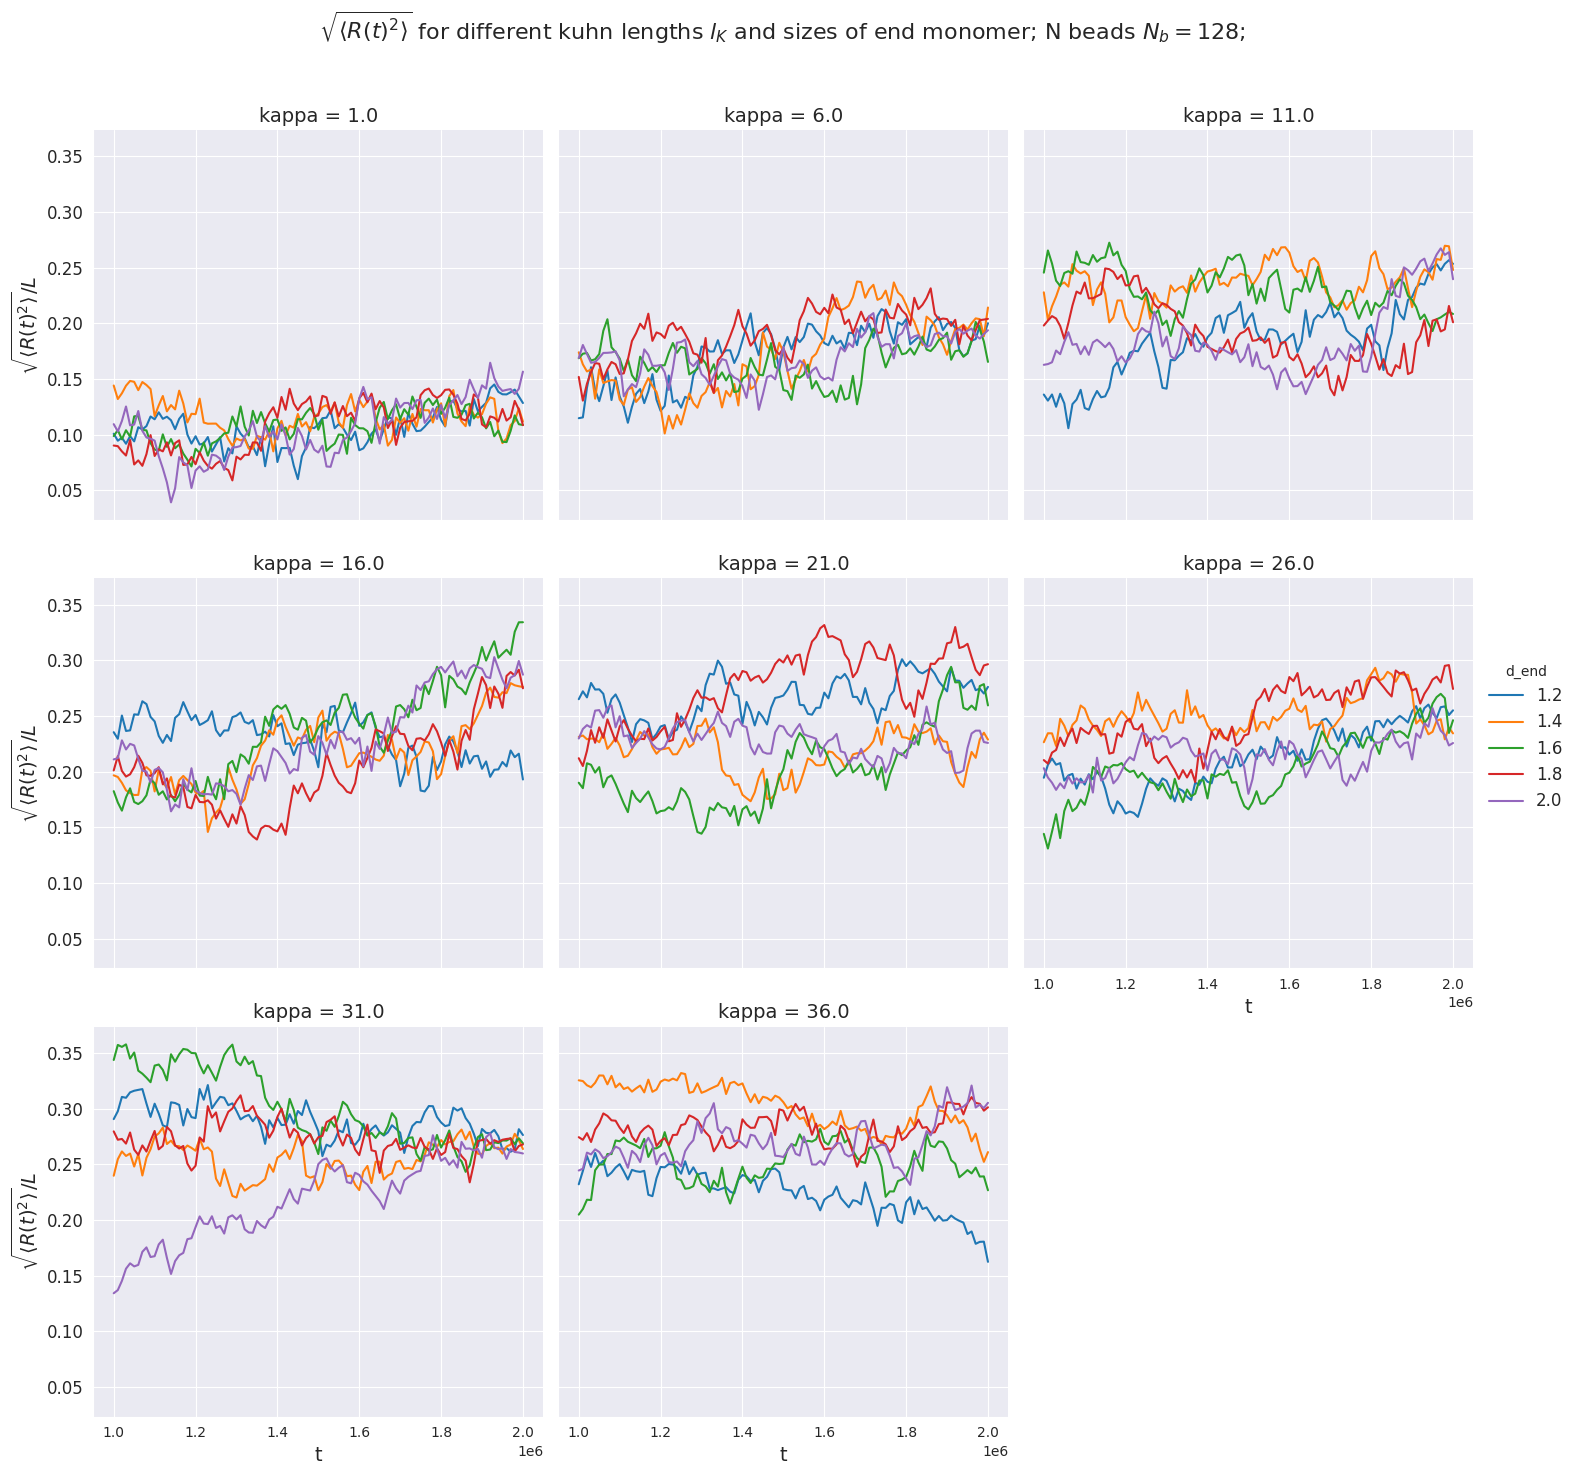

In [80]:
def plot_R(df_ete_mean: pd.DataFrame, d_end_colors) -> sns.FacetGrid:
    df = df_ete_mean.copy()
    col_name = "$\sqrt{{\\langle R(t)^2 \\rangle }} / L$"
    df[col_name] = np.sqrt(df["R^2"]) / L_src
    g = sns.FacetGrid(df.reset_index(), col="kappa", col_wrap=3, hue="d_end", sharey=True, sharex=True,
                      palette=d_end_colors, legend_out=True, height=5)
    g.map(sns.lineplot, "t", col_name)
    g.figure.subplots_adjust(top=0.9)
    g.figure.suptitle(
        f'$\sqrt{{\\langle R(t)^2 \\rangle }}$ for different kuhn lengths $l_K$ and sizes of end monomer; '
        f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$;'
    )
    g.add_legend()
    return g


d_end_colors = sns.color_palette(n_colors=len(d_ends))
kappa_colors = sns.color_palette(n_colors=len(kappas))

plot_R(df_ete_mean, d_end_colors)
plt.show()

## Equilibrium statistics

In [81]:
t_equilibrium = conf.simulation_config.variables["n_relax_steps"] if not CONTINUE else CONTINUE_t_equilibrium
t_equilibrium

1000000

In [82]:
df_trajectory_unfolded_equi = df_trajectory_unfolded_kappas_d_ends.loc[
    df_trajectory_unfolded_kappas_d_ends["t"] > t_equilibrium]
df_trajectory_unfolded_equi

,t,id,type,x,y,z,molecule-ID,kappa,d_end
512,1010000,1,1,0.000000,0.000000,0.000000,1,1.0,1.2
513,1010000,2,1,-0.159927,-0.017451,-0.956566,1,1.0,1.2
514,1010000,3,2,0.089256,0.834283,-1.256020,1,1.0,1.2
515,1010000,4,2,0.709848,0.986735,-0.510908,1,1.0,1.2
516,1010000,5,2,1.236620,0.666198,0.232452,1,1.0,1.2
...,...,...,...,...,...,...,...,...,...
2068475,2000000,508,2,-0.642658,6.268630,-6.913930,4,36.0,2.0
2068476,2000000,509,2,-0.092918,7.045920,-7.041510,4,36.0,2.0
2068477,2000000,510,2,0.497885,7.784340,-7.190840,4,36.0,2.0
2068478,2000000,511,2,1.122970,8.435290,-7.510580,4,36.0,2.0


In [83]:
df_ete_equi = df_ete.iloc[df_ete.index.get_level_values("t") >= t_equilibrium]
df_ete_equi

R_x       R_y       R_z          R  \
kappa d_end molecule-ID t                                                  
1.0   1.2   1           1000000 -0.870683  14.16120 -4.131960  14.777374   
                        1010000  1.051970   7.96739  0.613874   8.059949   
                        1020000 -1.003450  10.09510 -1.954870  10.331480   
                        1030000  2.000600   9.51666  1.972450   9.922690   
                        1040000  6.824480   3.99521  4.800400   9.250896   
...                                   ...       ...       ...        ...   
36.0  2.0   4           1960000 -9.593660  10.32960 -6.070200  15.348820   
                        1970000 -8.739560   9.50169 -4.936400  13.821363   
                        1980000 -1.838220  12.70480 -4.565360  13.624739   
                        1990000 -2.635800  11.00090 -3.797850  11.932766   
                        2000000  1.898920   8.97820 -7.729220  11.998117   

                                   t/LJ         R^2  
kappa d_end molecule-ID t                            
1.0   1.2   1           1000000  2500.0  218.370768  
                        1010000  2525.0   64.962786  
                        1020000  2550.0  106.739473  
                        1030000  2575.0   98.459777  
                        1040000  2600.0   85.579070  
...                                 ...         ...  
36.0  2.0   4           1960000  4900.0  235.586276  
                        1970000  4925.0  191.030067  
                        1980000  4950.0  185.633508  
                        1990000  4975.0  142.390907  
                        2000000  5000.0  143.954814  

[16160 rows x 6 columns]

In [84]:
df_ete_mean_equi = df_ete_mean.iloc[df_ete_mean.index.get_level_values("t") > t_equilibrium]
df_ete_mean_equi

R^2        l_K
kappa d_end t                              
1.0   1.2   1010000   135.866468   1.854017
            1020000   143.531319   1.854017
            1030000   128.186721   1.854017
            1040000   147.655155   1.854017
            1050000   134.134830   1.854017
...                          ...        ...
36.0  2.0   1960000  1560.974605  68.870000
            1970000  1374.675231  68.870000
            1980000  1398.289199  68.870000
            1990000  1369.986720  68.870000
            2000000  1413.417286  68.870000

[4000 rows x 2 columns]

### Mean bond length

In [85]:
l_b = conf.initial_system_config.system_config.bond_length
l_b

0.97

### Mean contour length

In [86]:
L_contour = l_b * (conf.initial_system_config.system_config.n_monomers - 1)
L_contour

123.19

### Kuhn lengths

Svaneborg (8)

In [87]:
l_ks = kremer_grest.bare_kuhn_length(np.array(kappas), l_b)
l_ks

array([ 1.85401695, 10.67085829, 20.37000013, 30.07      , 39.77      ,
       49.47      , 59.17      , 68.87      ])

In [88]:
l_ks / L_contour

array([0.01505006, 0.08662114, 0.16535433, 0.24409449, 0.32283465,
       0.4015748 , 0.48031496, 0.55905512])

Estimate from fit (Worm-like chain model, Hinczewski):

In [89]:
PATH_DF_LK_ESTIMATE = PATH_DATA_PROCESSED / "l_K-estimate.csv"

if PATH_DF_LK_ESTIMATE.exists():
    l_ks_estimate = pd.read_csv(PATH_DF_LK_ESTIMATE, index_col=["kappa", "d_end"])
else:
    l_ks_estimate = transform.estimate_kuhn_length_df(
        df_trajectory_unfolded_equi,
        group_by_params=["kappa", "d_end"]
    )
    l_ks_estimate.to_csv(PATH_DF_LK_ESTIMATE, index=True)

l_ks_estimate

l_K     d_l_K
kappa d_end                     
1.0   1.2     1.686333  0.021416
      1.4     1.721260  0.021806
      1.6     1.698541  0.021653
      1.8     1.730904  0.021965
      2.0     1.677199  0.021270
6.0   1.2     9.328633  0.138802
      1.4     8.948240  0.120490
      1.6     9.536026  0.151681
      1.8     9.149916  0.149841
      2.0     9.064006  0.135734
11.0  1.2    15.213958  0.364572
      1.4    14.444689  0.306864
      1.6    15.060766  0.315825
      1.8    14.927289  0.295798
      2.0    15.090340  0.310265
16.0  1.2    20.339424  0.494783
      1.4    17.706179  0.457407
      1.6    18.081096  0.496273
      1.8    15.891443  0.501813
      2.0    18.520971  0.563502
21.0  1.2    21.946416  0.660600
      1.4    16.839402  0.538565
      1.6    19.060835  0.540665
      1.8    20.344937  0.586809
      2.0    19.872725  0.625744
26.0  1.2    20.787025  0.621141
      1.4    22.703292  0.688855
      1.6    20.422067  0.676180
      1.8    19.621478  0.645588
      2.0    21.987133  0.742326
31.0  1.2    25.428596  0.804431
      1.4    24.864927  0.859353
      1.6    23.396044  0.673875
      1.8    22.109984  0.721619
      2.0    20.624819  0.682290
36.0  1.2    25.232004  0.904156
      1.4    27.288272  0.919705
      1.6    24.919899  0.915636
      1.8    21.294079  0.785098
      2.0    23.316998  0.754493

In [90]:
l_ks_estimate / L_contour

l_K     d_l_K
kappa d_end                    
1.0   1.2    0.013689  0.000174
      1.4    0.013972  0.000177
      1.6    0.013788  0.000176
      1.8    0.014051  0.000178
      2.0    0.013615  0.000173
6.0   1.2    0.075726  0.001127
      1.4    0.072638  0.000978
      1.6    0.077409  0.001231
      1.8    0.074275  0.001216
      2.0    0.073577  0.001102
11.0  1.2    0.123500  0.002959
      1.4    0.117255  0.002491
      1.6    0.122256  0.002564
      1.8    0.121173  0.002401
      2.0    0.122496  0.002519
16.0  1.2    0.165106  0.004016
      1.4    0.143731  0.003713
      1.6    0.146774  0.004029
      1.8    0.128999  0.004073
      2.0    0.150345  0.004574
21.0  1.2    0.178151  0.005362
      1.4    0.136695  0.004372
      1.6    0.154727  0.004389
      1.8    0.165151  0.004763
      2.0    0.161318  0.005080
26.0  1.2    0.168740  0.005042
      1.4    0.184295  0.005592
      1.6    0.165777  0.005489
      1.8    0.159278  0.005241
      2.0    0.178481  0.006026
31.0  1.2    0.206418  0.006530
      1.4    0.201842  0.006976
      1.6    0.189918  0.005470
      1.8    0.179479  0.005858
      2.0    0.167423  0.005539
36.0  1.2    0.204822  0.007340
      1.4    0.221514  0.007466
      1.6    0.202288  0.007433
      1.8    0.172856  0.006373
      2.0    0.189277  0.006125

Absolute difference of analytical l_K and estimated l_K relative to analytical l_K

In [91]:
l_ks_estimate.groupby("d_end", as_index=False, group_keys=True).apply(lambda df: (abs(df["l_K"] - l_ks) / l_ks))

   kappa  d_end
0  1.0    1.2      0.090444
   6.0    1.2      0.125784
   11.0   1.2      0.253119
   16.0   1.2      0.323597
   21.0   1.2      0.448167
   26.0   1.2      0.579805
   31.0   1.2      0.570245
   36.0   1.2      0.633629
1  1.0    1.4      0.071605
   6.0    1.4      0.161432
   11.0   1.4      0.290884
   16.0   1.4      0.411168
   21.0   1.4      0.576580
   26.0   1.4      0.541070
   31.0   1.4      0.579771
   36.0   1.4      0.603771
2  1.0    1.6      0.083859
   6.0    1.6      0.106349
   11.0   1.6      0.260640
   16.0   1.6      0.398700
   21.0   1.6      0.520723
   26.0   1.6      0.587183
   31.0   1.6      0.604596
   36.0   1.6      0.638160
3  1.0    1.8      0.066404
   6.0    1.8      0.142532
   11.0   1.8      0.267193
   16.0   1.8      0.471518
   21.0   1.8      0.488435
   26.0   1.8      0.603366
   31.0   1.8      0.626331
   36.0   1.8      0.690808
4  1.0    2.0      0.095370
   6.0    2.0      0.150583
   11.0   2.0      0.259188
   1

### Number of Kuhn segments $N_K$

Estimate $N_K = L / l_K$ as in Svaneborg (6)

In [92]:
N_Ks = (L_contour / l_ks)
N_Ks

array([66.44491561, 11.54452591,  6.04761901,  4.09677419,  3.09756098,
        2.49019608,  2.08196721,  1.78873239])

### End-to-End distance squared $\langle R^2 \rangle$

Estimate $\langle R^2 \rangle$ as average over ensemble and then over time in equilibrium

In [93]:
df_ete_sq_t_mean_kappas_dend = transform.calculate_ete_sq_t_avg_df_kappas_dend(df_ete_mean_equi, t_equilibrium)
df_ete_sq_t_mean_kappas_dend

R^2
kappa d_end             
1.0   1.2     174.985922
      1.4     209.136097
      1.6     177.765111
      1.8     184.900698
      2.0     180.877305
6.0   1.2     463.747083
      1.4     465.922873
      1.6     413.802340
      1.8     561.698661
      2.0     441.369840
11.0  1.2     538.594606
      1.4     849.350204
      1.6     812.971595
      1.8     565.990470
      2.0     540.437853
16.0  1.2     808.259123
      1.4     726.008887
      1.6     891.695697
      1.8     654.158976
      2.0     829.810683
21.0  1.2    1080.891579
      1.4     714.947376
      1.6     638.523241
      1.8    1186.296408
      2.0     801.716408
26.0  1.2     698.937906
      1.4     957.166642
      1.6     641.172990
      1.8     958.111304
      2.0     695.744082
31.0  1.2    1270.820709
      1.4     985.951637
      1.6    1388.968475
      1.8    1134.196056
      2.0     753.256715
36.0  1.2     772.545945
      1.4    1393.759552
      1.6     963.497309
      1.8    1209.173487
      2.0    1110.159295

### Summarize statistics by kappas and d_end

In [94]:
df_kuhn_summary = df_ete_sq_t_mean_kappas_dend.copy()
df_kuhn_summary["l_K"] = kremer_grest.bare_kuhn_length(
    df_kuhn_summary.index.get_level_values("kappa").to_numpy(dtype=float), l_b)
df_kuhn_summary["N_K"] = L_contour / df_kuhn_summary["l_K"]
df_kuhn_summary

R^2        l_K        N_K
kappa d_end                                   
1.0   1.2     174.985922   1.854017  66.444916
      1.4     209.136097   1.854017  66.444916
      1.6     177.765111   1.854017  66.444916
      1.8     184.900698   1.854017  66.444916
      2.0     180.877305   1.854017  66.444916
6.0   1.2     463.747083  10.670858  11.544526
      1.4     465.922873  10.670858  11.544526
      1.6     413.802340  10.670858  11.544526
      1.8     561.698661  10.670858  11.544526
      2.0     441.369840  10.670858  11.544526
11.0  1.2     538.594606  20.370000   6.047619
      1.4     849.350204  20.370000   6.047619
      1.6     812.971595  20.370000   6.047619
      1.8     565.990470  20.370000   6.047619
      2.0     540.437853  20.370000   6.047619
16.0  1.2     808.259123  30.070000   4.096774
      1.4     726.008887  30.070000   4.096774
      1.6     891.695697  30.070000   4.096774
      1.8     654.158976  30.070000   4.096774
      2.0     829.810683  30.070000   4.096774
21.0  1.2    1080.891579  39.770000   3.097561
      1.4     714.947376  39.770000   3.097561
      1.6     638.523241  39.770000   3.097561
      1.8    1186.296408  39.770000   3.097561
      2.0     801.716408  39.770000   3.097561
26.0  1.2     698.937906  49.470000   2.490196
      1.4     957.166642  49.470000   2.490196
      1.6     641.172990  49.470000   2.490196
      1.8     958.111304  49.470000   2.490196
      2.0     695.744082  49.470000   2.490196
31.0  1.2    1270.820709  59.170000   2.081967
      1.4     985.951637  59.170000   2.081967
      1.6    1388.968475  59.170000   2.081967
      1.8    1134.196056  59.170000   2.081967
      2.0     753.256715  59.170000   2.081967
36.0  1.2     772.545945  68.870000   1.788732
      1.4    1393.759552  68.870000   1.788732
      1.6     963.497309  68.870000   1.788732
      1.8    1209.173487  68.870000   1.788732
      2.0    1110.159295  68.870000   1.788732

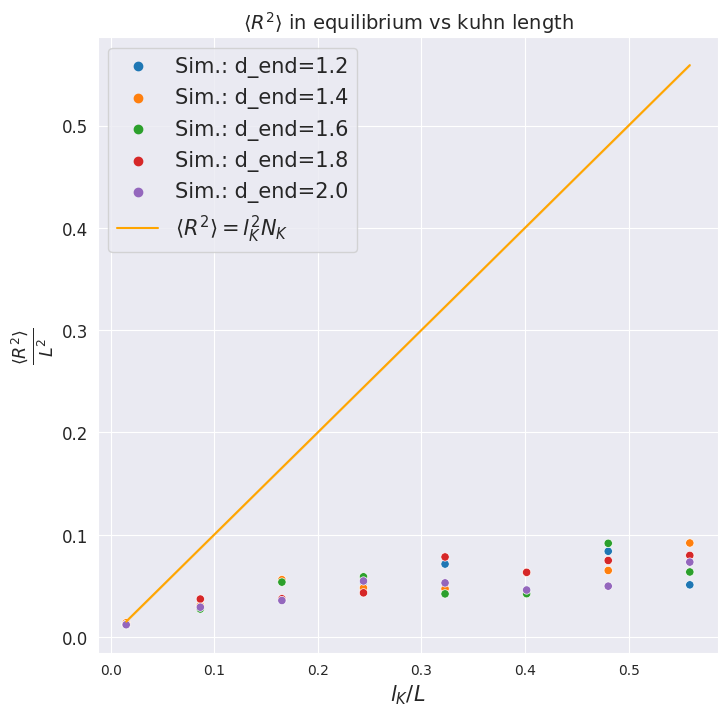

In [95]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(
    x=df_kuhn_summary["l_K"] / L_contour,
    y=df_kuhn_summary["R^2"] / L_contour ** 2,
    ax=ax,
    hue=df_kuhn_summary.index.get_level_values("d_end"),
    palette=d_end_colors,
)

sns.lineplot(
    x=df_kuhn_summary["l_K"] / L_contour,
    y=(df_kuhn_summary["l_K"] ** 2 * df_kuhn_summary["N_K"]) / L_contour ** 2,
    label=r"$\langle R^2 \rangle = l_K^2 N_K$",
    color="orange",
    legend=False
)

ax.set(
    title=r"$\langle R^2 \rangle$ in equilibrium vs kuhn length",
    xlabel="$l_K / L$",
    ylabel=r"$\frac{\langle R^2 \rangle}{L^2}$"
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, [f"Sim.: d_end={d}" for d in labels[:5]] + labels[5:], fontsize=15)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(18)

In [96]:
df_kuhn_summary["l_K"] ** 2 * df_kuhn_summary["N_K"] / df_kuhn_summary["R^2"]

kappa  d_end
1.0    1.2       1.305227
       1.4       1.092094
       1.6       1.284821
       1.8       1.235238
       2.0       1.262714
6.0    1.2       2.834612
       1.4       2.821375
       1.6       3.176741
       1.8       2.340299
       2.0       2.978325
11.0   1.2       4.659126
       1.4       2.954471
       1.6       3.086676
       1.8       4.433609
       2.0       4.643236
16.0   1.2       4.583089
       1.4       5.102311
       1.6       4.154246
       1.8       5.662726
       2.0       4.464058
21.0   1.2       4.532616
       1.4       6.852625
       1.6       7.672808
       1.8       4.129884
       2.0       6.110972
26.0   1.2       8.719243
       1.4       6.366926
       1.6       9.504782
       1.8       6.360649
       2.0       8.759269
31.0   1.2       5.735783
       1.4       7.393012
       1.6       5.247889
       1.8       6.426713
       2.0       9.676850
36.0   1.2      10.981994
       1.4       6.087202
       1.6       8.805520

### ETE change $ \langle (\Delta R(t))^2 \rangle $

In [97]:
df_ete_change_equi = transform.calculate_ens_avg_df_ete_change_kappas_dend(df_ete_equi)
df_ete_change_equi["l_K"] = kremer_grest.bare_kuhn_length(df_ete_change_equi["kappa"].astype(float), l_b=l_b)
df_ete_change_equi

,dR^2,kappa,d_end,l_K
t,,,,
1000000,0.000000,1.0,1.2,1.854017
1010000,27.574960,1.0,1.2,1.854017
1020000,13.127311,1.0,1.2,1.854017
1030000,39.323045,1.0,1.2,1.854017
1040000,81.062539,1.0,1.2,1.854017
...,...,...,...,...
1960000,442.857368,36.0,2.0,68.870000
1970000,447.345530,36.0,2.0,68.870000
1980000,453.003020,36.0,2.0,68.870000


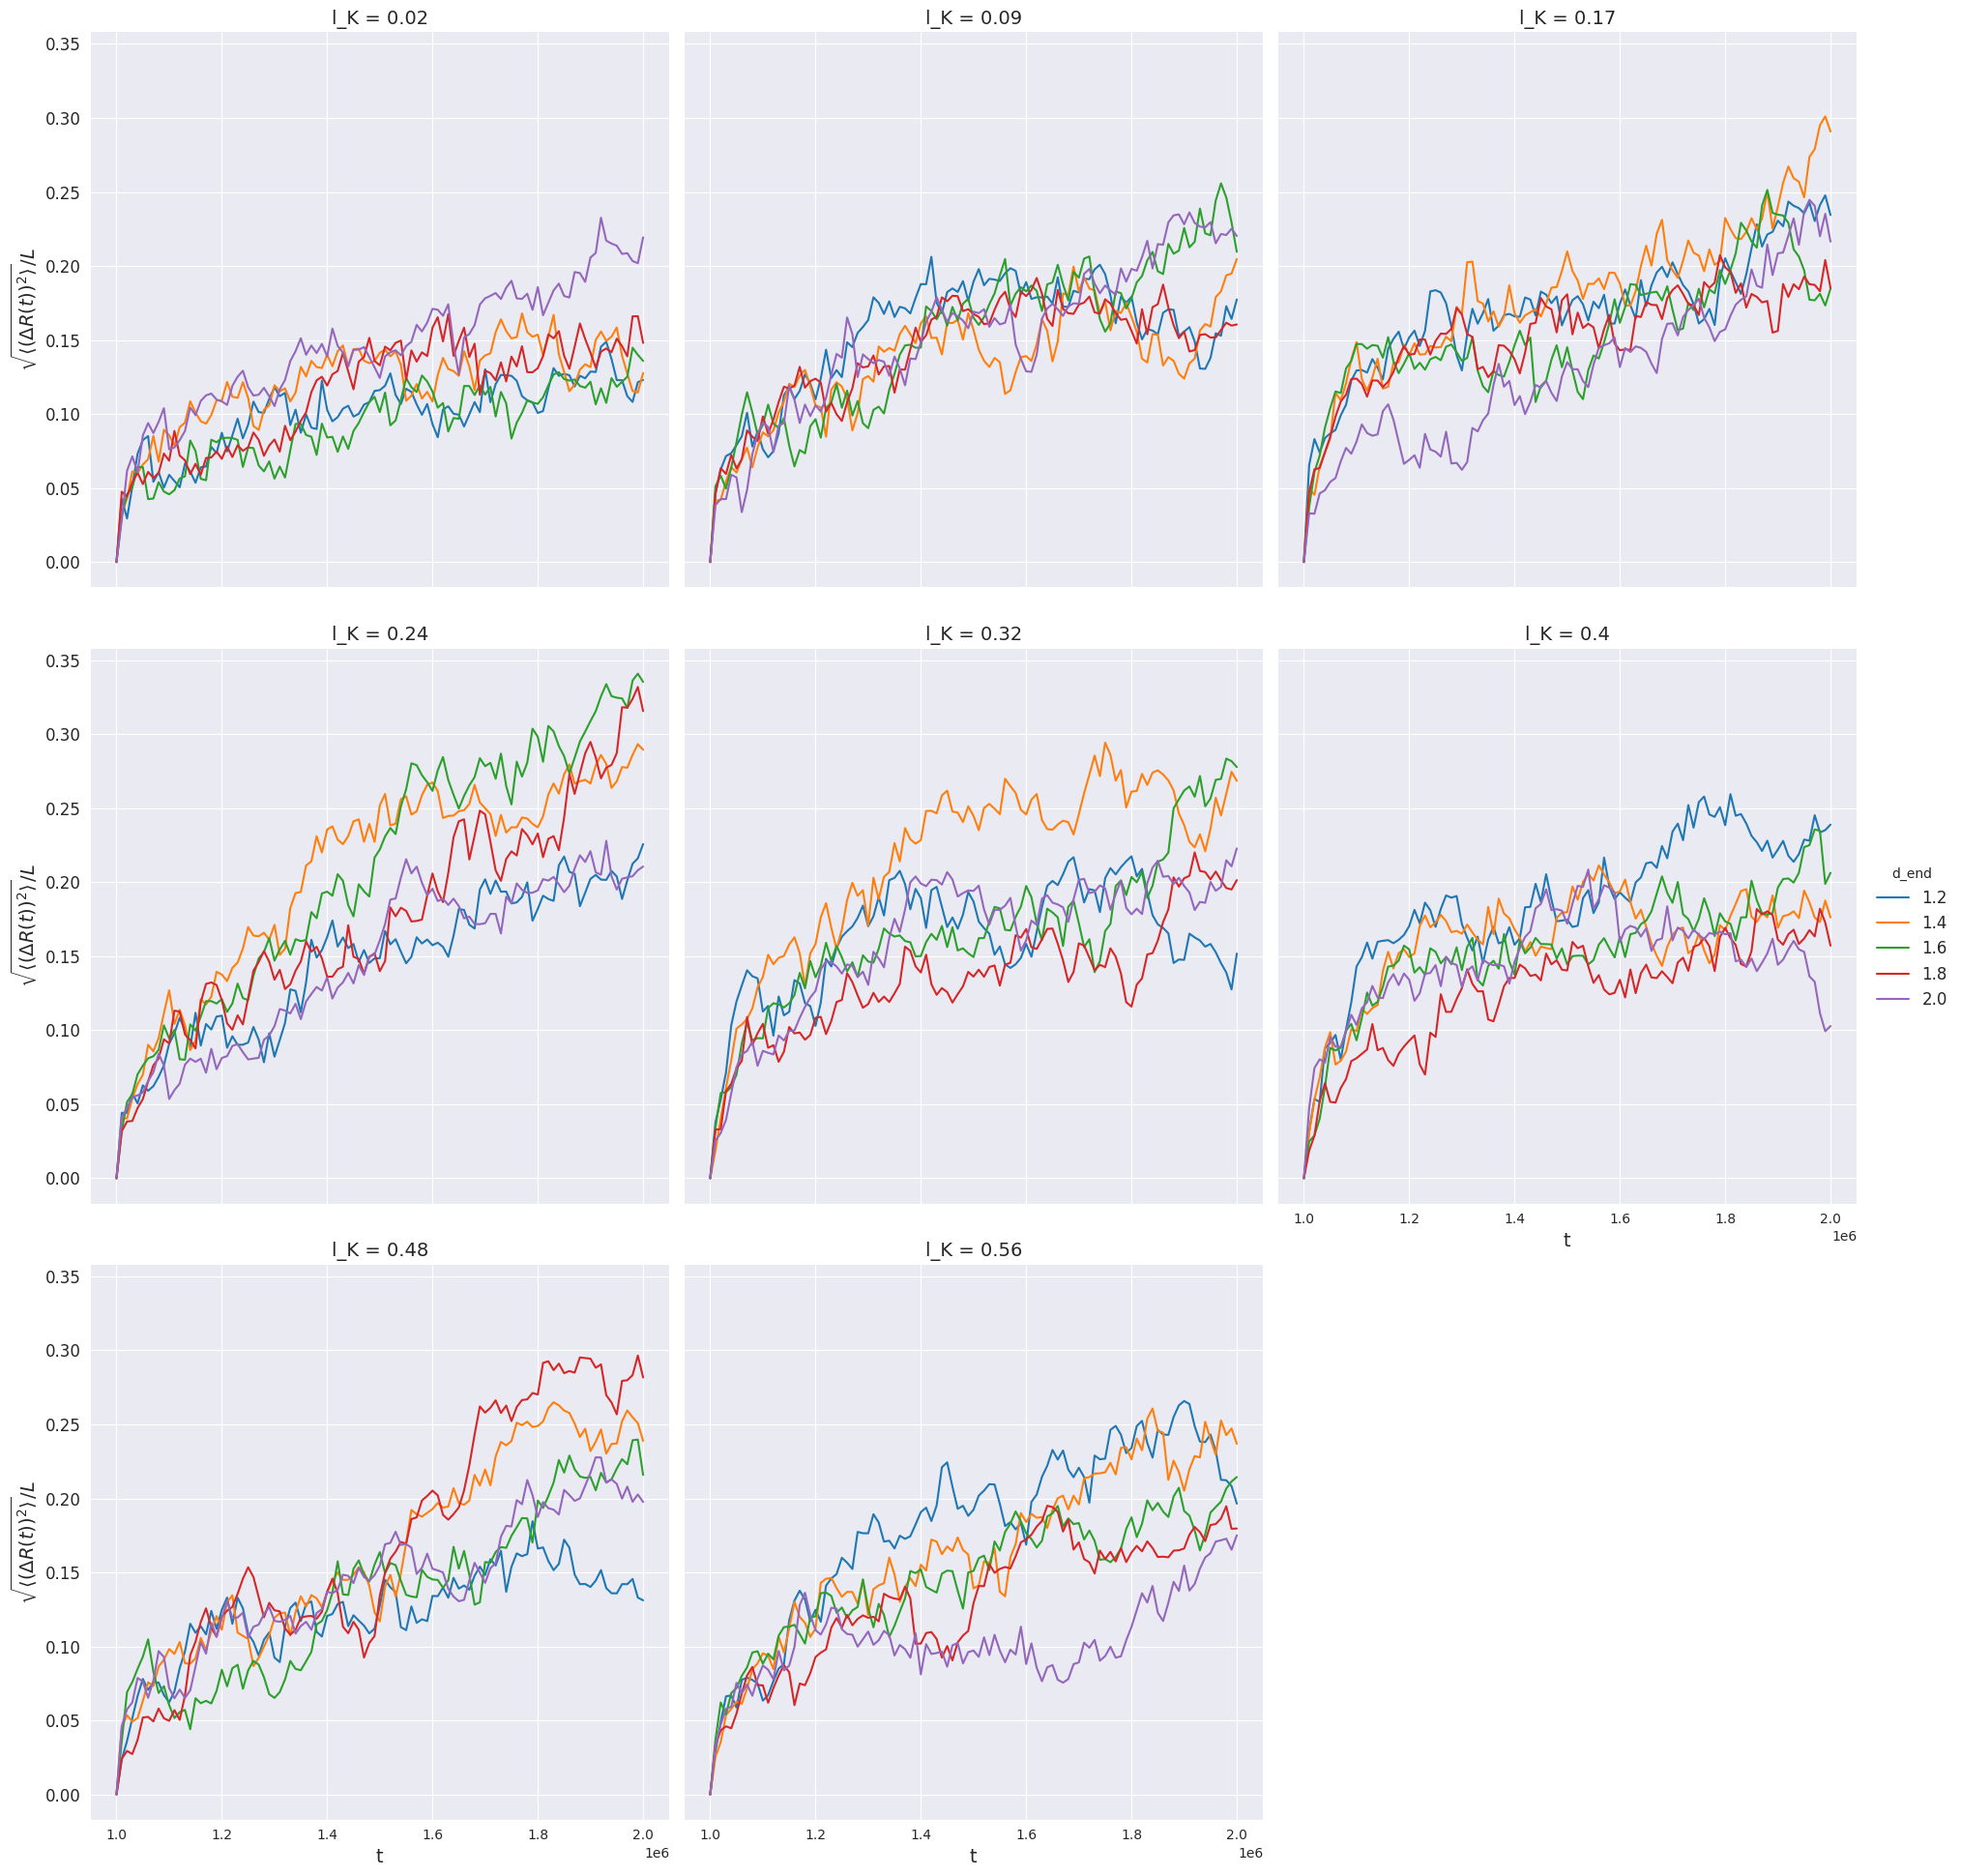

In [98]:
def plot_raw_dR():
    df = df_ete_change_equi.copy()
    df["l_K"] = (df["l_K"] / L_contour).round(2).astype("category")
    dR_col = "$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$"
    df[dR_col] = np.sqrt(df["dR^2"]) / L_contour

    g = sns.FacetGrid(
        df.reset_index(),
        col="l_K",
        col_wrap=3,
        hue="d_end",
        palette=d_end_colors,
        height=6.5
    )

    g.map(
        sns.lineplot,
        "t",
        dR_col,
    )

    g.add_legend()


plot_raw_dR()